In [1]:
# 단어 벡터 가져오기
from gensim.models import Word2Vec

# 모델 파일 경로
model_file = "final_w2v.model"

# Word2Vec 모델 불러오기
model = Word2Vec.load(model_file)

# 단어 벡터 불러오기
word_vectors = model.wv

In [119]:
import pandas as pd
import numpy as np

df = pd.read_csv('Word_AverageVector2.csv')
df = df[['Word','year']]
df.head()

,Word,year
0,14_foreground_detection,2014
1,14_moving_object_detection,2014
2,14_background_modeling,2014
3,14_text_detection,2014
4,14_bag_of_feature,2014


In [120]:
import pandas as pd
import re
from tqdm.notebook import tqdm
import numpy as np
import networkx as nx
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from networkx.algorithms.community import greedy_modularity_communities
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
stops=set(stopwords.words('english')) # 불용어 설정
import warnings
warnings.filterwarnings('ignore')

# input_directory="C:/researchdata/input"
# output_directory="C:/researchdata/output"

class Product():
    def __init__(self,id:int, name:str, year:int, raw_gene:list):
        self.id=id
        self.name=name
        self.year=year
        self.raw_gene=raw_gene
        self.genotype=None
        self.taxon=None
        self.ancestor=None
        self.descendant=None
        self.ancestors=None
        self.descendants=None
    
# 두 객체의 유전자형의 코사인 유사도 구하는 함수    
def cosine_similarity(product_i,product_j):
    A=product_i.genotype
    B=product_j.genotype
    return dot(A, B)/(norm(A)*norm(B))

# Output Network list, product_list에 taxon 할당ㅡ 
# input : 제품 목록, 연도 목록, 임계값, 제품명 -> 네트워크 분석 시행
# 제품 간의 유사도를 계산하고, 임계값 이상인 경우에만 그래프에 엣지를 추가
# 그래프의 커뮤니티를 추출하고, 제품에 taxon 값을 할당
def Network(input_product_list,input_year_list,input_threshold,product_name,label_representation=True):
    # Output Network list 
    temp_network_list=[] # 네트워크 그래프들을 담을 리스트
    # color_list
    color_list=list(mcolors.BASE_COLORS) # 그래프 노드에 적용할 색상
    color_list+=list(mcolors.TABLEAU_COLORS)
    color_list+=list(mcolors.CSS4_COLORS)

    for year in tqdm(input_year_list):
        temp_title=str(product_name)+"_"+str(year)+"_"+str(input_threshold) # 결과 파일 이름 생성
        temp_products=[x for x in product_list if x.yera!="No"] # input_product_list에서 해당 연도와 일치하는 제품들로 구성
        #product_list -> input_product_list(?), yera -> year(?)
        temp_products=[x for x in temp_products if int(float(x.year))==year] # 해당 연도와 일치하는 제품들
        temp_G=nx.Graph() # 그래프 초기화
        for i in range(len(temp_products)): 
            temp_G.add_node(temp_products[i].name) # 노드 추가
            for j in range(i+1,len(temp_products)):
                if temp_products[i]!=temp_products[j]:
                    temp_weight=cosine_similarity(temp_products[i],temp_products[j])
                if temp_weight>=input_threshold: # 유사도 계산해 임계값 이상인 경우에만 그래프에 엣지 추가
                    temp_G.add_edge(temp_products[i].name,temp_products[j].name,weight=temp_weight)

        # Community Dictionary
        c=greedy_modularity_communities(temp_G) # 그래프의 커뮤니티 추출
        print(len(c))
        # Taxon Assign (커뮤니티에 속하는 제품들에 taxon 값 할당)
        for i in range(len(c)):
            for product in temp_products:
                if product.name in list(c[i]):
                    product.taxon=i 

        # Node 크기를 위한 dictionary
        d = nx.degree_centrality(temp_G)

        # Network Layout
        pos1=nx.spring_layout(temp_G)

        # 그래프 시각화
        plt.figure(figsize=(20,20))
        for i in range(len(c)):
            nx.draw_networkx_nodes(temp_G,pos=pos1,node_color=color_list[i],nodelist = list(c[i]), node_size = [d[n] * 1000 for n in list(c[i])])  
            if label_representation:
                nx.draw_networkx_labels(temp_G,pos=pos1,labels={n:n for n in list(c[i])},font_size=10,alpha=0.8,font_color=color_list[i])
            else:
                pass

        nx.draw_networkx_edges(temp_G,pos=pos1,alpha=0.5,edge_color="grey")
        #labels={n:n.name for n in temp_G.nodes}
        #nx.draw_networkx_labels(temp_G,pos=pos1,labels={n:n for n in temp_G.nodes},font_size=10,alpha=0.5)

        nx.write_edgelist(temp_G, temp_title+".txt", data=False,delimiter=",")
        nx.write_edgelist(temp_G, temp_title+"_weight.txt", data=["weight"],delimiter=",")
        plt.savefig(temp_title+".jpg",dpi=200,transparent=True,bbox_inches="tight")    
        temp_network_list.append(temp_G) # 그래프를 파일로 저장하고 temp_network_list에 그래프 추가

    return temp_network_list

# product를 csv로 추출
# 실제 코드 시에는 많이 소거해야 할 부분
def product_csv(input_product_list,temp_title):
    temp_result_df=pd.DataFrame()
    for product in tqdm(input_product_list):
        # 각 제품의 속성 추가, 이를 temp_result_df에 저장
        temp_list=[]
        ## 수정1
        ## title, keywords, year, community
        temp_list.append(product.id)
        temp_list.append(product.name)
        temp_list.append(product.year)
        temp_list.append(product.taxon)
        temp_list.append(product.genotype)
        temp_list.append(product.raw_gene)
        # 추가한 값들을 데이터프레임에 추가함.
        temp_result_df=temp_result_df.append(pd.Series(temp_list),ignore_index=True)
  
    temp_result_df.columns=["id","name","year","taxon","genotype","raw_gene"]
    temp_result_df.to_csv(str(temp_title)+'.csv',index=False)
    # product_genotype을 수직으로 쌓아 넘파이 배열로 저장
    # 1. temp_title을 문자열로 변환하여 파일 이름으로 사용합니다.
    # 2. input_product_list에 있는 각 제품의 genotype 속성을 가져와서 리스트 컴프리헨션을 사용하여 배열로 변환합니다.
    # 3. np.vstack 함수를 사용하여 배열들을 수직으로 쌓아 하나의 큰 배열을 생성합니다.
    # 4. np.save 함수를 사용하여 생성된 배열을 바이너리 파일로 저장합니다. 파일 이름은 temp_title로 지정
    np.save(str(temp_title),np.vstack([product.genotype for product in input_product_list]))


In [127]:
### after ###
df = pd.read_csv('Word_AverageVector2.csv')
df = df[df['year']<=2016]
df.reset_index(drop=True, inplace=True)

# 벡터값을 각 칼럼에 추가

# 각 단어의 벡터 표현 얻기
word_embeddings = []
for word in df['Word']:
    if word in word_vectors:
        word_embedding = word_vectors[word]
        word_embeddings.append(word_embedding)
    else:
        # 해당 단어의 벡터 표현이 없는 경우, 원하는 처리를 수행하세요.
        # 예를 들어, 벡터를 0 벡터로 초기화하거나, 다른 특정 값을 할당할 수 있습니다.
        word_embedding = [0.0] * model.vector_size
        word_embeddings.append(word_embedding)

# 벡터 표현을 DataFrame에 추가
embedding_dim = model.vector_size
# embedding_columns = [f"embedding_{i+1}" for i in range(embedding_dim)]
# embedding_df = pd.DataFrame(word_embeddings, columns=embedding_columns)
# df = pd.concat([df, embedding_df], axis=1)

In [128]:
# 연속형 리스트
Continuous_var_list=[f"vector{i+1}" for i in range(embedding_dim)]

- 일단 시행 시는 정규화 하지 않을거임

In [129]:
df.head()

,Word,vector1,vector2,vector3,vector4,vector5,vector6,vector7,vector8,vector9,...,vector92,vector93,vector94,vector95,vector96,vector97,vector98,vector99,vector100,year
0,14_foreground_detection,0.171250,-0.058348,-0.236916,-0.372838,0.098600,-0.944303,0.019384,-0.043284,0.144273,...,0.155077,-0.106139,-0.484185,-0.183091,-0.185632,0.419995,-0.671733,0.586380,-0.763019,2014
1,14_moving_object_detection,-0.538383,0.090087,0.535199,-0.112763,0.362069,-0.789586,-0.189391,0.478218,0.081175,...,-0.008773,-0.392723,0.422669,0.243592,0.532844,-0.121090,0.107887,0.191973,-0.014675,2014
2,14_background_modeling,0.122600,-0.235151,-0.025713,-0.280608,-0.195637,-0.111950,-0.034477,0.336512,-0.217859,...,0.031099,0.369310,0.254604,0.383636,0.265438,-0.263793,-0.533481,0.291137,-0.249719,2014
3,14_text_detection,-0.198683,0.033477,-0.035807,-0.383138,0.029227,-0.504464,-0.173439,0.155094,-0.128309,...,0.054848,-0.028247,0.021527,0.374016,0.095247,-0.001439,-0.667456,0.473586,-0.709460,2014
4,14_bag_of_feature,-0.336808,-0.680102,-0.121993,-0.426524,-0.070240,-0.838477,-0.233819,0.173468,-0.040254,...,-0.004663,-0.161345,0.068499,-0.152859,-0.070005,0.249166,-0.774534,0.430947,-0.522017,2014


In [130]:
product_list=[]

for i in range(len(df)):
    temp_id=i
    temp_name=df.loc[i,"Word"]
    temp_year=int(df.loc[i,"year"])
    
    temp_raw_gene=list(df.columns)[1:-1] # Name, Year 제외
    product_list.append(Product(temp_id,temp_name,temp_year,temp_raw_gene))
    
for i in range(len(product_list)):
    # 해당 제품의 genotype 속성 생성, 이를 Numpy 배열로 초기화
    product_list[i].genotype=np.array(df.loc[i][3:])

In [131]:
product_list[0]
# product_csv(product_list, "rifle_products")는 product_list에 있는 
# 제품 정보를 CSV 파일로 추출하는 함수인 product_csv를 호출
# rifle_products.csv, rifle_products.npy 생성
product_csv(product_list,"word_products")

  0%|          | 0/8603 [00:00<?, ?it/s]

In [132]:
# -*- coding: utf-8 -*-
"""Tree.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1aVf5DOYOhl_FwSwjVv4j7RlxZPW41nl4
"""

import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
from numpy import dot
from numpy.linalg import norm
import networkx as nx
from numpy import dot
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from networkx.algorithms.community import greedy_modularity_communities
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import pydot # graphviz를 파이썬에서 사용하기 편리하게, 그래프에서 시각화하기 편하게함.
from networkx.drawing.nx_pydot import graphviz_layout
from matplotlib import cm

In [133]:
# 특정 분류 나타내는 객체 생성위한 클래스
class TAXON():
    def __init__(self,id:int, name:str, year:int):
        self.id=id
        self.name=name
        self.year=year
        self.representative=None
        self.genes=None
        self.products=None
        self.genotype=None
        self.ancestor=None
        self.similarity=None
        self.ancestors=None
        self.descendants=None
        self.representative_vector=None
        self.innovativeness = None
        self.path_dependency = None
        self.btwnCent = None
        self.visit = None
# 트리노드 생성 클래스
class TreeNode():
    def __init__(self,input_taxon):
        self.taxon = input_taxon
        self.child = None
        self.pos=(None,None)

class Tree():
    def __init__(self, root: TreeNode) -> None:
        self.root = root # 트리 루트 설정
        self.pos={}
        self.count=0  
    # 노드 방문하여 출력하고 위치 (pos) 선정
    def visit(self, node: TreeNode, depth:int) -> None:
      #print("--"*depth, node.taxon.name)
        print("--"*depth, node.taxon.representative)
        self.pos[node]=(depth,self.count*10)
        self.count+=1
    # 깊이 우선 탐색을 사용하여 트리를 순회하며 노드 방문
    def __DFT_preorderHelp(self, curNode, depth:int)->None:
      #base case
        if curNode ==None:
            return
        self.visit(curNode, depth)

        #child
        for childNode in curNode.child :
            self.__DFT_preorderHelp(childNode, depth+1)


    def DFT_preorder(self) -> None:
        self.__DFT_preorderHelp(self.root, 0)

"""# Functions"""
# 코사인 유사도
def cosine_similarity(A,B):
    return dot(A, B)/(norm(A)*norm(B))
# 자카드 유사도
def jaccard_similarity(A,B):
    return len(set(A).intersection(set(B)))/len(set(A).union(set(B)))
# 벡터 A와 B, 그리고 범주형 변수(Categorical) 리스트를 인자로 받아 Gower 유사도를 계산
# 범주형 변수는 정수 형태로 표현, 연속형 변수는 실수로 표현
# def Gower_similarity(A,B,Cat_list):
#     temp_value=[]
#   # Categorical Part : 범주형인 경우
#     for i in range(len(Cat_list)):
#         if A[i]==B[i]:
#             temp_value.append(1)
#         else:
#             temp_value.append(0)
#   # Continuous Part : 연속형인 경우
#     for i in range(len(Cat_list),len(A)):
#         temp_value.append(
#              1-abs(A[i]-B[i])
#         )
#     return sum(temp_value)/len(temp_value)

def Gower_similarity(A, B):
    vector_size = len(A)
    assert vector_size == len(B), "Vectors A and B must have the same length."
    
    # Calculate Gower similarity for continuous variables
    continuous_similarity = 1 - np.sum(np.abs(np.array(A) - np.array(B))) / vector_size
    
    return continuous_similarity

In [134]:
# """# Rifle"""

# vectors=np.load("word_products.npy",allow_pickle=True)
# df["vector"]=list(vectors)

# vector1부터 vector100까지의 칼럼 이름을 생성
vector_columns = [f'vector{i}' for i in range(1, 101)]
df['vector'] = df.apply(lambda row: [row[col] for col in vector_columns], axis=1)

In [135]:
df

,Word,vector1,vector2,vector3,vector4,vector5,vector6,vector7,vector8,vector9,...,vector93,vector94,vector95,vector96,vector97,vector98,vector99,vector100,year,vector
0,14_foreground_detection,0.171250,-0.058348,-0.236916,-0.372838,0.098600,-0.944303,0.019384,-0.043284,0.144273,...,-0.106139,-0.484185,-0.183091,-0.185632,0.419995,-0.671733,0.586380,-0.763019,2014,"[0.1712504884865331, -0.0583480461704822, -0.2..."
1,14_moving_object_detection,-0.538383,0.090087,0.535199,-0.112763,0.362069,-0.789586,-0.189391,0.478218,0.081175,...,-0.392723,0.422669,0.243592,0.532844,-0.121090,0.107887,0.191973,-0.014675,2014,"[-0.5383834226808527, 0.0900870817631744, 0.53..."
2,14_background_modeling,0.122600,-0.235151,-0.025713,-0.280608,-0.195637,-0.111950,-0.034477,0.336512,-0.217859,...,0.369310,0.254604,0.383636,0.265438,-0.263793,-0.533481,0.291137,-0.249719,2014,"[0.1225996736535116, -0.2351506384163114, -0.0..."
3,14_text_detection,-0.198683,0.033477,-0.035807,-0.383138,0.029227,-0.504464,-0.173439,0.155094,-0.128309,...,-0.028247,0.021527,0.374016,0.095247,-0.001439,-0.667456,0.473586,-0.709460,2014,"[-0.1986832174537866, 0.0334774822388824, -0.0..."
4,14_bag_of_feature,-0.336808,-0.680102,-0.121993,-0.426524,-0.070240,-0.838477,-0.233819,0.173468,-0.040254,...,-0.161345,0.068499,-0.152859,-0.070005,0.249166,-0.774534,0.430947,-0.522017,2014,"[-0.3368076677679231, -0.680101546491578, -0.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8598,16_failure_detection,-0.315166,0.464927,0.585389,0.188115,0.259916,-0.024900,-0.629334,0.526430,-0.243239,...,-0.309463,0.182141,-0.070622,0.418783,-0.481448,0.144974,0.319196,-0.232098,2016,"[-0.3151662091544845, 0.4649271225524053, 0.58..."
8599,16_basal_ganglion,0.139558,0.303522,0.703282,0.002085,0.161262,0.111929,-0.588052,0.352608,-0.514049,...,0.048082,0.139259,0.144259,0.369111,-0.438966,-0.016221,0.316509,-0.326892,2016,"[0.1395577304065227, 0.3035217177841747, 0.703..."
8600,16_cheating,-0.120654,0.254013,0.844640,0.003174,0.362992,-0.075654,-0.487040,0.421064,-0.199089,...,-0.180358,0.053808,-0.013255,0.301480,-0.555413,0.170746,0.207717,-0.080108,2016,"[-0.1206541439158874, 0.2540126711266981, 0.84..."
8601,16_cleaning_robot,-0.101374,0.356900,0.638731,0.028276,0.186776,0.027563,-0.510754,0.402981,-0.247853,...,-0.044547,-0.035535,0.021957,0.267160,-0.382861,0.137702,0.168525,-0.159088,2016,"[-0.1013739064066229, 0.3568995220325233, 0.63..."


In [136]:
df['vector']

0       [0.1712504884865331, -0.0583480461704822, -0.2...
1       [-0.5383834226808527, 0.0900870817631744, 0.53...
2       [0.1225996736535116, -0.2351506384163114, -0.0...
3       [-0.1986832174537866, 0.0334774822388824, -0.0...
4       [-0.3368076677679231, -0.680101546491578, -0.1...
                              ...                        
8598    [-0.3151662091544845, 0.4649271225524053, 0.58...
8599    [0.1395577304065227, 0.3035217177841747, 0.703...
8600    [-0.1206541439158874, 0.2540126711266981, 0.84...
8601    [-0.1013739064066229, 0.3568995220325233, 0.63...
8602    [-0.063398163275499, 0.2219450569123421, 0.577...
Name: vector, Length: 8603, dtype: object

In [137]:
"""## Coloring"""
# 실제로는 사용 x 코드

# 220418
# 먼저 gene_dictionary_df를 불러옴
# gene_dictionary_df=pd.read_csv("word_gene_dict.csv")
# gene_dictionary_df


df["year"]=df["year"].astype(int)
df.head()

,Word,vector1,vector2,vector3,vector4,vector5,vector6,vector7,vector8,vector9,...,vector93,vector94,vector95,vector96,vector97,vector98,vector99,vector100,year,vector
0,14_foreground_detection,0.171250,-0.058348,-0.236916,-0.372838,0.098600,-0.944303,0.019384,-0.043284,0.144273,...,-0.106139,-0.484185,-0.183091,-0.185632,0.419995,-0.671733,0.586380,-0.763019,2014,"[0.1712504884865331, -0.0583480461704822, -0.2..."
1,14_moving_object_detection,-0.538383,0.090087,0.535199,-0.112763,0.362069,-0.789586,-0.189391,0.478218,0.081175,...,-0.392723,0.422669,0.243592,0.532844,-0.121090,0.107887,0.191973,-0.014675,2014,"[-0.5383834226808527, 0.0900870817631744, 0.53..."
2,14_background_modeling,0.122600,-0.235151,-0.025713,-0.280608,-0.195637,-0.111950,-0.034477,0.336512,-0.217859,...,0.369310,0.254604,0.383636,0.265438,-0.263793,-0.533481,0.291137,-0.249719,2014,"[0.1225996736535116, -0.2351506384163114, -0.0..."
3,14_text_detection,-0.198683,0.033477,-0.035807,-0.383138,0.029227,-0.504464,-0.173439,0.155094,-0.128309,...,-0.028247,0.021527,0.374016,0.095247,-0.001439,-0.667456,0.473586,-0.709460,2014,"[-0.1986832174537866, 0.0334774822388824, -0.0..."
4,14_bag_of_feature,-0.336808,-0.680102,-0.121993,-0.426524,-0.070240,-0.838477,-0.233819,0.173468,-0.040254,...,-0.161345,0.068499,-0.152859,-0.070005,0.249166,-0.774534,0.430947,-0.522017,2014,"[-0.3368076677679231, -0.680101546491578, -0.1..."


In [138]:
# Categorical_var_list=["UAction","Act","Type","Foldable","Bullpup"]
#Continuous_var_list=["Cal_mm","Cleng_mm","L_mm","FL_mm","W_kg","gr_n","feed_n","Mv_m","Bullpup","Maximum range_m","effective range_m","BL_mm"]
Continuous_var_list=[f"vector{i+1}" for i in range(embedding_dim)]
# Cat_list=Categorical_var_list
All_var_list = Continuous_var_list
Taxa_list=[]


for i in range(len(df)):
    temp_id=i
    temp_name=str(temp_id)
    temp_year=df.loc[i,"year"]
    temp_representative=df.loc[i,"Word"]
    # genotype
    temp_representative_vector=df.loc[i,"vector"]
    # TAXON 클래스 호출해서 추가
    Taxa_list.append(TAXON(temp_id,temp_name,temp_year))
    Taxa_list[-1].representative=temp_representative+"_"+str(temp_year)
    Taxa_list[-1].representative_vector=temp_representative_vector


Taxa_list[0].__dict__ # 첫번째 객체의 속성 확인 -> 해당 객체의 속성과 값들이 딕셔너리 형태로 출력

{'id': 0,
 'name': '0',
 'year': 2014,
 'representative': '14_foreground_detection_2014',
 'genes': None,
 'products': None,
 'genotype': None,
 'ancestor': None,
 'similarity': None,
 'ancestors': None,
 'descendants': None,
 'representative_vector': [0.1712504884865331,
  -0.0583480461704822,
  -0.2369159646495653,
  -0.3728379181814952,
  0.0985995137914933,
  -0.9443031535075422,
  0.0193836841438161,
  -0.0432842071576599,
  0.1442731575582895,
  0.0714880651791821,
  -0.5025371783004519,
  -0.4782478253504163,
  0.0221716833398922,
  -0.0430167595643484,
  1.0713428964086793,
  -0.1413561364701181,
  -0.1420482698564515,
  -1.0238788842893485,
  0.516240597294088,
  -0.8834299837941664,
  -0.1747536668712232,
  -1.0091716322165571,
  -0.4576031742944267,
  -1.0273597880609726,
  0.3519159858206924,
  0.1038190953498869,
  0.0335803638179704,
  0.440131541733679,
  0.2725119397142215,
  1.0618566745205928,
  0.3836737562199695,
  -0.9586695747637892,
  0.2475604425723615,
  0.0769

In [139]:
Taxa_list

 ...]

In [140]:
### 실행 x ###
# 220418
# Taxa_list(사실은 그냥 단일 소총 제품)의 representative_vector의 3번째가 Type을 의미
# representative_vector의 3번째가 0이면 manual
# representative_vector의 3번째가 1,2이면 Auto, Semi-Auto
# TAXON 객체에 genes에 manual인지 Auto인지 정보를 assign

#Taxa_list[10].representative_vector[0]
# 조건에 따라 장르 추가 (사용 x) 
# for taxon in Taxa_list:
#     if taxon.representative_vector[0]==2:
#         taxon.genes="breech_block"
#     if taxon.representative_vector[0]==1:
#         taxon.genes="bolt_action"
#     if taxon.representative_vector[0]==3:
#         taxon.genes="recoil"
#     if taxon.representative_vector[0]==4:
#         taxon.genes="lever_action"
#     if taxon.representative_vector[0]==0:
#         taxon.genes="Gas_operated"

In [141]:
#-------------------------------색을 작동방식으로
# 실제로는 칼럼명 변경해서 할 예정
df['Union'] = 0
for taxon in Taxa_list:
    # rifle.csv 파일에 대해서 시행
    for i in range(len(df)):
        if taxon.id == i:
            # rifle.csv파일의 Union칼럼의 값을 taxon의 products로 변형
            taxon.products=df.loc[i,'Union']
            print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122


3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953
3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021


5738
5739
5740
5741
5742
5743
5744
5745
5746
5747
5748
5749
5750
5751
5752
5753
5754
5755
5756
5757
5758
5759
5760
5761
5762
5763
5764
5765
5766
5767
5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937


7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741
7742
7743
7744
7745
7746
7747
7748
7749
7750
7751
7752
7753
7754
7755
7756
7757
7758
7759
7760
7761
7762
7763
7764
7765
7766
7767
7768
7769
7770
7771
7772
7773
7774
7775
7776
7777
7778
7779
7780
7781
7782
7783
7784
7785
7786
7787
7788
7789
7790
7791
7792
7793
7794
7795
7796
7797
7798
7799
7800
7801
7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813
7814
7815
7816
7817
7818
7819
7820
7821
7822
7823
7824
7825
7826
7827
7828
7829


In [142]:
# 특정 taxon에 대해 단일 ancestor을 찾는 함수
# 유사도 비교, 가장 유사한 ancestor 반환
# descendant_taxon : 후손, 조상을 찾아야 할 대상
# 후손과 여러 개의 세습들의 유사도를 계산하고, 후손의 연도보다 이전에 있는 세습 중 가장 유사한 조상을 찾아 반환하는 함수
def Ancestor_Descendant_Single(descendant_taxon,taxa_list):
    # descendant_taxon의 연도(descendant_taxon.year)가 taxa_list에 있는 세습들의 연도 중 가장 작은 값인지 확인합니다. 만약 가장 작은 값이라면, 후손이 가장 오래된 세습이므로 조상을 찾을 수 없습니다. 
    # 따라서 None을 반환
    if descendant_taxon.year==min([taxon.year for taxon in taxa_list]):
        return None 
    else:
        temp_list=[]
        for taxon in taxa_list:
            # 세습의 연도(taxon.year)가 descendant_taxon의 연도보다 작은 경우
            if taxon.year < descendant_taxon.year:
                #temp_list.append(cosine_similarity(taxon.representative_vector,descendant_taxon.representative_vector))
                # 유사도를 계산하여 temp_list에 추가합니다.
                # Gower_similarity 함수 사용, 여기서는 cosine로 대체
#                 temp_list.append(Gower_similarity(taxon.representative_vector,descendant_taxon.representative_vector))
                temp_list.append(cosine_similarity(taxon.representative_vector,descendant_taxon.representative_vector))
            else:
                # -1을 temp_list에 추가합니다. (후손보다 미래에 있는 세습의 유사도는 계산되지 않으므로 -1로 설정합니다.)
                temp_list.append(-1)
                # temp_list에서 가장 큰 값을 찾아 인덱스를 반환하여 해당 인덱스에 해당하는 조상(taxon)을 taxa_list에서 찾아 반환
        return taxa_list[temp_list.index(max(temp_list))]

# Matching Evolutionary Relationship
for taxon in tqdm(Taxa_list):
    # taxon의 조상을 Ancestor_Descendant_Single 함수로 찾음
    # 하나의 taxon, Taxa_list전체의 유사도를 계산해서 가장 유사한 조상 찾아 반환
    taxon.ancestor=Ancestor_Descendant_Single(taxon,Taxa_list)
    #taxon.ancestor=Ancestor_Descendant_Single(taxon,Taxa_list)

  0%|          | 0/8603 [00:00<?, ?it/s]

In [143]:
# 각 해당 Taxa_list의 후손 찾아서 저장
for ancestor in tqdm(Taxa_list):
    temp_list=[]
    for descendant in Taxa_list:
        if descendant.ancestor==ancestor:
            temp_list.append(descendant) # 후손을 찾아서 리스트에 추가
    ancestor.descendants=temp_list

  0%|          | 0/8603 [00:00<?, ?it/s]

In [144]:
# 중복없는 연도 리스트
year_list=sorted(list(set(df["year"])))

temp_title="Rifle"

Root=TAXON(-1,"root",year_list[0]-1) # 루트 생성, ID는 -1, 이름은 root, 연도는 첫번째 연도보다 1 작은 값으로 설정
Root.representative="root" 
t_root = TreeNode(Root) # 루트를 기반으로 트리 루트 노드 생성

Node_list=[]
for taxon in Taxa_list:
    # 각 taxon을 기반으로 트리 노드 생성, Node_list에 추가
    Node_list.append(TreeNode(taxon)) 

temp_list=[]
for Node in Node_list:
    # 첫번째 연도와 동일한 연도를 가진 노드를 찾아 임시 리스트에 추가
    if Node.taxon.year==year_list[0]:
        temp_list.append(Node) 
# 트리의 루트 노드의 자식 노드로서 첫번째 연도와 동일한 연도를 가진 노드들 생성
# 트리의 루토 노드의 자식 노드로 설정
t_root.child=temp_list 
# 루트 노드를 'Node_list'의 첫번째 연도와 동일한 연도를 가진 노드 설정
# Node_list 첫번째 노드에 루트 노드 삽입
Node_list.insert(0,t_root) 

for Node in tqdm(Node_list):
    # 현재 노드의 세습(taxon)의 연도가 첫 번째 연도보다 크거나 같은 경우
    if Node.taxon.year>=year_list[0]:
        Node.child=[]
        # 현재 노드의 세습의 후손(descendants)을 반복하면서 Node_list의 노드와 비교하여 후손과 일치하는 노드를 찾고
        # 해당 노드를 현재 노드의 자식으로 추가합니다.
        for descendant in Node.taxon.descendants:
            for Node_j in Node_list:
                if descendant.name==Node_j.taxon.name:
                    Node.child.append(Node_j) # 노드의 후손들과 Node_list를 비교하여 자식 노드를 찾고, Node.child에 추가

# myTree는 t_root를 루트로 하는 트리(Tree)의 인스턴스를 생성합니다.
# myTree.DFT_preorder()는 생성된 트리의 전위 순회를 수행하여 트리를 탐색하고, 각 노드를 출력합니다.                    
myTree = Tree(t_root) # 생성된 트리의 인스턴스 생성
myTree.DFT_preorder() # 트리의 전위 순회를 수행해 트리를 탐색, 각 노드 출력

  0%|          | 0/8604 [00:00<?, ?it/s]

 root
-- 14_foreground_detection_2014
-- 14_moving_object_detection_2014
-- 14_background_modeling_2014
-- 14_text_detection_2014
-- 14_bag_of_feature_2014
-- 14_image_classification_2014
-- 14_compressed_domain_2014
-- 14_feature_detection_2014
-- 14_application_system_2014
-- 14_feature_tracking_2014
-- 14_action_classification_2014
-- 14_dynamic_routing_2014
-- 14_face_alignment_2014
-- 14_self_calibration_2014
-- 14_image_recognition_2014
-- 14_mesh_network_2014
-- 14_target_recognition_2014
-- 14_hand_gesture_recognition_2014
-- 14_image_coding_2014
-- 14_content_based_image_retrieval_2014
-- 14_active_shape_model_2014
-- 14_image_registration_2014
-- 14_feature_representation_2014
-- 14_image_preprocessing_2014
-- 14_channel_utilization_2014
-- 14_gait_recognition_2014
-- 14_face_tracking_2014
-- 14_high_speed_network_2014
-- 14_buffer_management_2014
-- 14_motion_estimation_2014
-- 14_corner_detection_2014
-- 14_language_modeling_2014
-- 14_backbone_network_2014
-- 14_human_acti

In [145]:
## 그래프를 생성하고, 그래프의 노드 간 연결을 정의하며, 그래프에서 중간 중심성을 계산하여 노드의 크기를 설정하는 과정을 수행
# 그래프를 생성하고, 노드 간의 연결을 설정하여 그래프를 구성합니다. 그래프에서 중간 중심성을 계산하여 노드의 크기를 설정할 수 있습니다. 
# 중간 중심성은 그래프에서 어떤 노드가 다른 노드들 간의 최단 경로상에서 얼마나 중요한 역할을 하는지를 측정하는 지표
# 이를 기준으로 노드의 크기를 결정하여 중요한 노드를 시각적으로 강조할 수 있습니다.
G=nx.DiGraph() # 방향 그래프 생성
# 초기 임계값 : 0
temp_threshold=0
for node in tqdm(Node_list):
    G.add_node(node.taxon.name) # 각 노드에 대해 그래프에 노드 추가 (node.taxon.name : 노드의 이름)
    # 노드가 자식을 가지고 있다면?
    if node.child:
        # 해당 자식 노드를 그래프에 추가, 부모와 자식 노드 사이 엣지 추가 -> ancestor, taxon 관계 그래프로 표현
        for temp_child in node.child:
            # 각 노드의 세습(taxon) 이름을 그래프(G)에 노드로 추가
            G.add_node(temp_child.taxon.name)
            # 각 자식 노드를 그래프(G)에 노드로 추가
            G.add_edge(node.taxon.name,temp_child.taxon.name)

temp_node_list = list(G.nodes) # 그래프의 모든 노드 저장
# 그래프에서 노드의 중간 중심성 계산
btwnCent = nx.betweenness_centrality(G, normalized=True, endpoints=False)
# 중간중심성 값을 기준으로 노드를 내림차순으로 결정
sorted_nodes = sorted(btwnCent.items(), key=lambda x:x[1], reverse=True)


  0%|          | 0/8604 [00:00<?, ?it/s]

In [146]:
product_df = pd.read_csv("word_products.csv", encoding='cp949')

In [147]:
vector_columns = [f'vector{i}' for i in range(1, 101)]
df['vector'] = df.apply(lambda row: [row[col] for col in vector_columns], axis=1)

In [148]:
product_df['genotype'] = df['vector']

In [149]:
product_df.head()

,id,name,year,taxon,genotype,raw_gene
0,0,14_foreground_detection,2014,NaN,"[0.1712504884865331, -0.0583480461704822, -0.2...","['vector1', 'vector2', 'vector3', 'vector4', '..."
1,1,14_moving_object_detection,2014,NaN,"[-0.5383834226808527, 0.0900870817631744, 0.53...","['vector1', 'vector2', 'vector3', 'vector4', '..."
2,2,14_background_modeling,2014,NaN,"[0.1225996736535116, -0.2351506384163114, -0.0...","['vector1', 'vector2', 'vector3', 'vector4', '..."
3,3,14_text_detection,2014,NaN,"[-0.1986832174537866, 0.0334774822388824, -0.0...","['vector1', 'vector2', 'vector3', 'vector4', '..."
4,4,14_bag_of_feature,2014,NaN,"[-0.3368076677679231, -0.680101546491578, -0.1...","['vector1', 'vector2', 'vector3', 'vector4', '..."


In [150]:
# 임시 리스트 초기화
temp_name_list = []
temp_btwn_list = []
temp_id_list = []
# 정렬된 노드의 이름과 중간 중심성 값을 기반으로 해당 정보를 임시 리스트에 추가, 이 때 root 노드는 제외
for k in tqdm(range(len(sorted_nodes))):
    # root노드가 아닐때 (시작 노드가 아닐 때)
    if sorted_nodes[k][0] != 'root':
        for i in range(len(product_df)):
            if int(product_df['id'][i]) == int(sorted_nodes[k][0]):
                temp_name_list.append(product_df['name'][i])
                temp_id_list.append(int(product_df['id'][i]))
                temp_btwn_list.append(sorted_nodes[k][1])

# 임시 리스트를 활용하여 temp_df를 생성하고, 열 이름과 해당 정보 할당
temp_df=pd.DataFrame()
temp_df['id'] = temp_id_list
temp_df['name'] = temp_name_list
temp_df['btwn'] = temp_btwn_list
#bt_list = betweeness centrality for setting node size (노드 크기 설정위한 임시리스트)
bt_list = []

# 임시 리스트 'temp_node_list'의 각 노드에 대해 중간 중심성 값을 기반으로 크기 설정, bt_list에 추가, root노드의 크기는 1로 설정
for i in tqdm(range(len(temp_node_list))):
    if temp_node_list[i] != 'root':
        for j in range(len(temp_df)):
            # temp_df 데이터프레임을 순회하면서 현재 노드의 ID와 일치하는 행을 찾습니다.
            if int(temp_node_list[i]) == int(temp_df['id'][j]):
                # 일치하는 행의 'btwn' 열의 값에 5000을 곱하고 1을 더하여 크기를 설정
                # ? 굳이 왜 5000을 곱했을까요...?
                bt_list.append(5000*(temp_df['btwn'][j])+1)
    else :
        bt_list.append(1)



  0%|          | 0/8604 [00:00<?, ?it/s]

  0%|          | 0/8604 [00:00<?, ?it/s]

In [151]:
year_name = {}
for i in range(len(Taxa_list)):
    year_name[Taxa_list[i].name] = Taxa_list[i].year
# 이 연도는 실제 반영시 수정 예정
# year_name['root'] = 2014
Taxa_list[0].genes

In [152]:
Taxa_list[0].__dict__

{'id': 0,
 'name': '0',
 'year': 2014,
 'representative': '14_foreground_detection_2014',
 'genes': None,
 'products': 0,
 'genotype': None,
 'ancestor': None,
 'similarity': None,
 'ancestors': None,
 'descendants': [],
 'representative_vector': [0.1712504884865331,
  -0.0583480461704822,
  -0.2369159646495653,
  -0.3728379181814952,
  0.0985995137914933,
  -0.9443031535075422,
  0.0193836841438161,
  -0.0432842071576599,
  0.1442731575582895,
  0.0714880651791821,
  -0.5025371783004519,
  -0.4782478253504163,
  0.0221716833398922,
  -0.0430167595643484,
  1.0713428964086793,
  -0.1413561364701181,
  -0.1420482698564515,
  -1.0238788842893485,
  0.516240597294088,
  -0.8834299837941664,
  -0.1747536668712232,
  -1.0091716322165571,
  -0.4576031742944267,
  -1.0273597880609726,
  0.3519159858206924,
  0.1038190953498869,
  0.0335803638179704,
  0.440131541733679,
  0.2725119397142215,
  1.0618566745205928,
  0.3836737562199695,
  -0.9586695747637892,
  0.2475604425723615,
  0.076943695

In [155]:
def phylogenetic_tree_Single(input_G,input_Node_list,input_style,input_lw,input_temp_title,name_mode,input_labels_list):
    pos1=graphviz_layout(input_G, prog="dot",root='root') # 그래프 레이아웃 설정
    #pos1=graphviz_layout(input_G, prog="twopi",root='root')
    temp_pos=pos1
    print(temp_pos)
    # 빈 딕셔너리로 초기화
    pos1={}
    for key in list(temp_pos.keys()):
        # 각 노드 위치 설정
        pos1[key]=[0,0] # 노드의 이름을 키로 가짐, 해당 노드의 좌표를 값으로 가짐
        pos1[key][0]=(temp_pos[key][0])  
        pos1[key][1]=(-temp_pos[key][1]) # temp_pos : graphviz_layout 함수를 통해 어은 좌표 정보를 저장한 변수
    fig = plt.figure(figsize=(18,10))
    ax=plt.subplot(111)
    
    # root node의 후손 연결해주기
#     for temp_child in input_Node_list[0].child:
#         temp_edge=(input_Node_list[0].taxon.name,temp_child.taxon.name)
#         # 선조, 후손 노드 연결하는 선 그림, 선을 그릴 위치, 스타일을 정함
#         ax.annotate("",
#                   xy=(pos1[temp_child.taxon.name][0],pos1[temp_child.taxon.name][1]),
#                   xytext=(pos1[input_Node_list[0].taxon.name][0],pos1[input_Node_list[0].taxon.name][1]),
#                   arrowprops=dict(
#                                 arrowstyle="-",  
#                                 lw=input_lw,
#                                 connectionstyle=input_style,
#                                 linewidth = 0.01,
#                                 #arrowstyle="wedge",
#                                 color="blue",
#                                 alpha=1
#                                 )
#                       )

    # root node이외의 선조 후손 관계 연결   
    for node in input_Node_list:
        if node.taxon.name!="root":
            if node.taxon.descendants:
                for descendant in node.taxon.descendants :
                  # coloring : 220418 후손 제품이 manual이면 파랑, Auto면 빨강
                    print(descendant.representative," : ", descendant.genes)
                    if node.taxon.ancestor != None:
                        # gower을 cosine으로 대체
                        node.taxon.similarity = cosine_similarity(node.taxon.representative_vector,node.taxon.ancestor.representative_vector)          


                    temp_edge=(node.taxon.name,descendant.name)
                    ax.annotate("",
                    xy=(pos1[descendant.name][0],pos1[descendant.name][1]),
                    xytext=(pos1[node.taxon.name][0],pos1[node.taxon.name][1]),
                    arrowprops=dict(
                                        arrowstyle="-",  
                                        lw = input_lw,
                                        connectionstyle=input_style,
                                        alpha=1
                                        )
                              )

    # 상하좌우 축 안보이게 설정
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False) # 축의 경계를 제거하여 차트의 외곽 경계를 깔끔하게
    # 범례를 생성하기 위해 사용하는 코드
    # 여기서도 labels은 한두개로 축소
    from matplotlib.lines import Line2D 

  # color bar
  # labeling  
    if name_mode:
        for node in input_Node_list:  
            if node.taxon.name!="root":
                # 노드의 이름 또는 대표값을 그래프 상에 텍스트로 표시
                ax.text(pos1[node.taxon.name][0],pos1[node.taxon.name][1],node.taxon.name,rotation=30,fontsize=5)
        plt.tight_layout()
        plt.savefig(input_temp_title+"_test_200_1.jpg",dpi=200,transparent=True,bbox_inches="tight")
        plt.savefig(input_temp_title+"_test_300_1.jpg",dpi=300,transparent=True,bbox_inches="tight")
    else:
    # labeling  
        for node in input_Node_list:
            if node.taxon.name!="root":
            # input_labels_list
                if node.taxon.name in input_labels_list:
                    ax.text(pos1[node.taxon.name][0],pos1[node.taxon.name][1],node.taxon.representative,rotation=30,fontsize=5)
        
        # 노드와 라벨을 그래프에 그림
        nx.draw_networkx_labels(G,pos=pos1,labels={"root":"Root"},font_size=5,font_weight="bold")
    # 노드 그리기
    nx.draw_networkx_nodes(input_G,pos=pos1,node_color="black",nodelist = temp_node_list, node_size = bt_list, alpha=1)
    nx.draw_networkx_nodes(input_G,pos=pos1,node_color="black",nodelist=["root"],alpha=1)
  
    # 차트 여백 최적화, 그래프 이미지 파일로 저장
    # dpi에 따라서 파일 다르게 저장
    plt.tight_layout()
    plt.savefig(input_temp_title+" type_test_200_1.jpg",dpi=200,transparent=True,bbox_inches="tight")
    plt.savefig(input_temp_title+" type_test_300_1.jpg",dpi=300,transparent=True,bbox_inches="tight")

In [115]:
len(Taxa_list[0].descendants)

0

{'root': (103040.0, 234.0), '0': (27.0, 162.0), '1': (99.0, 162.0), '2': (171.0, 162.0), '3': (243.0, 162.0), '4': (315.0, 162.0), '5': (387.0, 162.0), '6': (459.0, 162.0), '7': (531.0, 162.0), '8': (603.0, 162.0), '9': (675.0, 162.0), '10': (747.0, 162.0), '11': (819.0, 162.0), '12': (891.0, 162.0), '13': (963.0, 162.0), '14': (1035.0, 162.0), '15': (1107.0, 162.0), '16': (1179.0, 162.0), '17': (1251.0, 162.0), '18': (1323.0, 162.0), '19': (1395.0, 162.0), '20': (1467.0, 162.0), '21': (1539.0, 162.0), '22': (1611.0, 162.0), '23': (1683.0, 162.0), '24': (1755.0, 162.0), '25': (1827.0, 162.0), '26': (1899.0, 162.0), '27': (1971.0, 162.0), '28': (2043.0, 162.0), '29': (2115.0, 162.0), '30': (2187.0, 162.0), '31': (2259.0, 162.0), '32': (2331.0, 162.0), '33': (2403.0, 162.0), '34': (2475.0, 162.0), '35': (2547.0, 162.0), '36': (2619.0, 162.0), '37': (2691.0, 162.0), '38': (2763.0, 162.0), '39': (2835.0, 162.0), '40': (2907.0, 162.0), '41': (2979.0, 162.0), '42': (3051.0, 162.0), '43': (31

15_legged_robot_2015  :  None
15_cerebellum_2015  :  None
15_buffer_overflow_2015  :  None
15_automation_system_2015  :  None
15_pulse_coupled_neural_network_2015  :  None
15_motion_estimation_2015  :  None
15_noise_detection_2015  :  None
15_color_difference_2015  :  None
15_digital_watermark_2015  :  None
15_adaptive_method_2015  :  None
15_topic_detection_2015  :  None
15_fuzzy_rule_based_system_2015  :  None
16_line_detection_2016  :  None
15_continuous_speech_recognition_2015  :  None
15_cost_efficient_2015  :  None
15_micromachining_2015  :  None
16_mobile_robot_navigation_2016  :  None
15_dense_trajectory_2015  :  None
15_access_protocol_2015  :  None
15_cloud_system_2015  :  None
15_contrast_enhancement_2015  :  None
15_code_division_multiple_access_2015  :  None
15_constraint_optimization_2015  :  None
15_image_watermarking_2015  :  None
15_flying_robot_2015  :  None
15_infrared_video_2015  :  None
15_memory_usage_2015  :  None
15_hbasehadoop_2015  :  None
16_automatic_recogni

16_micro_electro_mechanical_system_2016  :  None
16_image_comparison_2016  :  None
16_smart_camera_2016  :  None
16_vanet_2016  :  None
16_control_loop_2016  :  None
16_brain_image_2016  :  None
16_adaptive_system_2016  :  None
16_gibbs_sampling_2016  :  None
16_data_security_2016  :  None
16_data_warehousing_2016  :  None
16_image_forgery_2016  :  None
16_dna_computing_2016  :  None
16_action_language_2016  :  None
16_feature_detection_2016  :  None
16_neuromorphic_computing_2016  :  None
16_collaborative_system_2016  :  None
16_data_locality_2016  :  None
16_emotion_recognition_2016  :  None
16_hand_segmentation_2016  :  None
16_contention_window_2016  :  None
16_color_quantization_2016  :  None
16_binary_particle_swarm_optimization_2016  :  None
16_android_operating_system_2016  :  None
16_human_robot_collaboration_2016  :  None
16_average_dwell_time_2016  :  None
16_power_grid_2016  :  None
16_docker_container_2016  :  None
16_array_antenna_2016  :  None
16_image_pyramid_2016  :  N

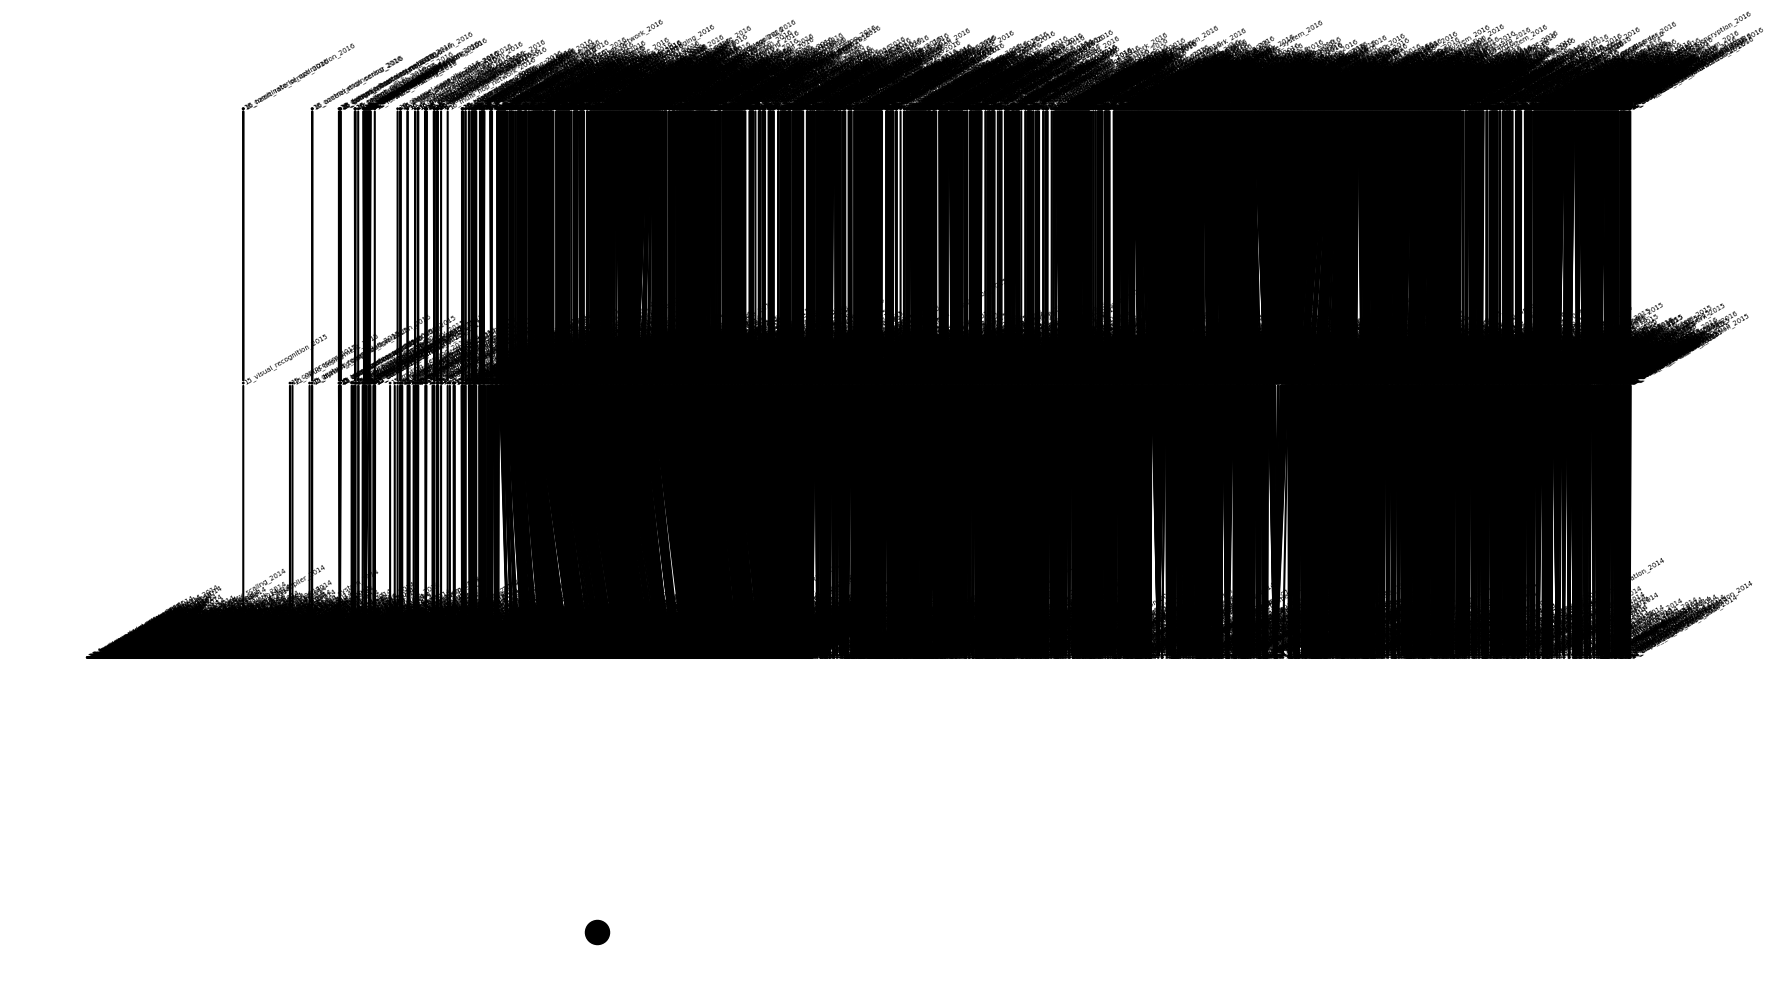

In [156]:
temp_lw=1.5
# phylogenetic_tree_Single 함수를 호출해 진화 트리를 그림 - G:그래프, Node_list:노드 리스트, arc3:선 스타일, temp_lw:선 두께,period:제목, False:라벨여부
phylogenetic_tree_Single(G,Node_list,"arc3",temp_lw,"computer tech",False,[taxon.name for taxon in Taxa_list])

In [30]:
# 1. 가장 끝년도 taxa_list만 가져오기
Taxa_list[:3]

In [38]:
Taxa_list[-5].ancestor.__dict__['id']

5393

In [ ]:
def phylogenetic_tree_Single(input_G,input_Node_list,input_style,input_lw,input_temp_title,name_mode,input_labels_list):
    pos1=graphviz_layout(input_G, prog="dot",root='root') # 그래프 레이아웃 설정
    #pos1=graphviz_layout(input_G, prog="twopi",root='root')
    temp_pos=pos1
    print(temp_pos)
    # 빈 딕셔너리로 초기화
    pos1={}
    for key in list(temp_pos.keys()):
        # 각 노드 위치 설정
        pos1[key]=[0,0] # 노드의 이름을 키로 가짐, 해당 노드의 좌표를 값으로 가짐
        pos1[key][0]=(temp_pos[key][0])  
        #pos1[key][index] : key의 x좌표와 y좌표를 나타냄. 여기서 [key][1]
        #pos1[key][1]=(year_name[key])
        pos1[key][1]=(-temp_pos[key][1]) # temp_pos : graphviz_layout 함수를 통해 어은 좌표 정보를 저장한 변수
    fig = plt.figure(figsize=(18,10))
    ax=plt.subplot(111)
    
    # root node의 후손 연결해주기
#     for temp_child in input_Node_list[0].child:
#         temp_edge=(input_Node_list[0].taxon.name,temp_child.taxon.name)
#         # 선조, 후손 노드 연결하는 선 그림, 선을 그릴 위치, 스타일을 정함
#         ax.annotate("",
#                   xy=(pos1[temp_child.taxon.name][0],pos1[temp_child.taxon.name][1]),
#                   xytext=(pos1[input_Node_list[0].taxon.name][0],pos1[input_Node_list[0].taxon.name][1]),
#                   arrowprops=dict(
#                                 arrowstyle="-",  
#                                 lw=input_lw,
#                                 connectionstyle=input_style,
#                                 linewidth = 0.01,
#                                 #arrowstyle="wedge",
#                                 color="blue",
#                                 alpha=1
#                                 )
#                       )

    # root node이외의 선조 후손 관계 연결   
    for node in input_Node_list:
        if node.taxon.name!="root":
            if node.taxon.descendants:
                for descendant in node.taxon.descendants :
                  # coloring : 220418 후손 제품이 manual이면 파랑, Auto면 빨강
                    print(descendant.representative," : ", descendant.genes)
                    ''' 
                  # coloring : Type에 따른 분류
                  if "Auto" == descendant.genes : 
                      temp_color = "royalblue"
                  elif "Semi-Auto" == descendant.genes : 
                      temp_color = "cadetblue"
                  elif "manual" == descendant.genes : 
                      temp_color = "aqua"
                  '''
                    if node.taxon.ancestor != None:
                        # gower을 cosine으로 대체
                        node.taxon.similarity = cosine_similarity(node.taxon.representative_vector,node.taxon.ancestor.representative_vector)          


                    temp_edge=(node.taxon.name,descendant.name)
                    ax.annotate("",
                    xy=(pos1[descendant.name][0],pos1[descendant.name][1]),
                    xytext=(pos1[node.taxon.name][0],pos1[node.taxon.name][1]),
                    arrowprops=dict(
                                        arrowstyle="-",  
                                        lw = input_lw,
                                        connectionstyle=input_style,
                                        alpha=1
                                        )
                              )

    # 상하좌우 축 안보이게 설정
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False) # 축의 경계를 제거하여 차트의 외곽 경계를 깔끔하게
    # 범례를 생성하기 위해 사용하는 코드
    # 여기서도 labels은 한두개로 축소
    from matplotlib.lines import Line2D 
#     labels = ['bolt_action', 'lever_action',  'breech_block', 'recoil','Gas_operated']
#     colors = ['blue', 'deepskyblue',  'aqua','Orange', 'red']
#     legend_elements = [Line2D([0], [0], color=color, lw=2, label=label) for label, color in zip(labels, colors)]
#     ax.legend(handles=legend_elements) # 범례 그래프에 추가

  # color bar
  # labeling  
    if name_mode:
        for node in input_Node_list:  
            if node.taxon.name!="root":
                # 노드의 이름 또는 대표값을 그래프 상에 텍스트로 표시
                ax.text(pos1[node.taxon.name][0],pos1[node.taxon.name][1],node.taxon.name,rotation=30,fontsize=5)
        plt.tight_layout()
        plt.savefig(input_temp_title+"_Phylogenetic Tree dot inverse_200_wo_label.jpg",dpi=200,transparent=True,bbox_inches="tight")
        plt.savefig(input_temp_title+"_Phylogenetic Tree dot inverse_300_wo_label.jpg",dpi=300,transparent=True,bbox_inches="tight")
    else:
    # labeling  
        for node in input_Node_list:
            if node.taxon.name!="root":
            # input_labels_list
            # 조건 추가
                if node.taxon.name in input_labels_list:
                    # 2014이면서 descendant가 null인 경우 pass
                    if (node.taxon.year==2014):
                        if node.taxon.descendant == null:
                            pass
                        else:
                            if len(node.taxon.descendant) == 1:  
                                ax.text(pos1[node.taxon.name][0],pos1[node.taxon.name][1],node.taxon.representative,rotation=30,fontsize=5)
                    else:
                        ax.text(pos1[node.taxon.name][0],pos1[node.taxon.name][1],node.taxon.representative,rotation=30,fontsize=5)
        
        # 노드와 라벨을 그래프에 그림
#         nx.draw_networkx_labels(G,pos=pos1,labels={"root":"Root"},font_size=5,font_weight="bold")
    # 노드 그리기
    nx.draw_networkx_nodes(input_G,pos=pos1,node_color="black",nodelist = temp_node_list, node_size = bt_list, alpha=1)
    nx.draw_networkx_nodes(input_G,pos=pos1,node_color="black",nodelist=["root"],alpha=1)
  
    # 차트 여백 최적화, 그래프 이미지 파일로 저장
    # dpi에 따라서 파일 다르게 저장
    plt.tight_layout()
    plt.savefig(input_temp_title+" type_Phylogenetic Tree dot inverse_200_w_label.jpg",dpi=200,transparent=True,bbox_inches="tight")
    plt.savefig(input_temp_title+" type_Phylogenetic Tree dot inverse_300_w_label.jpg",dpi=300,transparent=True,bbox_inches="tight")

In [112]:
len(Taxa_list)

29884

In [174]:
df = pd.read_csv('Word_AverageVector.csv')

In [175]:
df

,Word,vector1,vector2,vector3,vector4,vector5,vector6,vector7,vector8,vector9,...,vector92,vector93,vector94,vector95,vector96,vector97,vector98,vector99,vector100,year
0,14_foreground_detection,0.174309,-0.059390,-0.241147,-0.379496,0.100360,-0.961166,0.019730,-0.044057,0.146849,...,0.157846,-0.108035,-0.492831,-0.186361,-0.188947,0.427495,-0.683728,0.596851,-0.776644,2014
1,14_moving_object_detection,-0.547997,0.091696,0.544756,-0.114776,0.368535,-0.803685,-0.192773,0.486758,0.082624,...,-0.008930,-0.399736,0.430217,0.247942,0.542359,-0.123253,0.109814,0.195401,-0.014937,2014
2,14_background_modeling,0.124789,-0.239350,-0.026172,-0.285619,-0.199130,-0.113949,-0.035093,0.342522,-0.221750,...,0.031655,0.375905,0.259151,0.390486,0.270178,-0.268504,-0.543007,0.296336,-0.254178,2014
3,14_text_detection,-0.202231,0.034075,-0.036446,-0.389979,0.029748,-0.513473,-0.176536,0.157864,-0.130601,...,0.055828,-0.028751,0.021911,0.380695,0.096948,-0.001464,-0.679375,0.482043,-0.722129,2014
4,14_bag_of_feature,-0.342822,-0.692246,-0.124171,-0.434140,-0.071494,-0.853450,-0.237995,0.176565,-0.040972,...,-0.004746,-0.164226,0.069722,-0.155588,-0.071255,0.253615,-0.788365,0.438643,-0.531339,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29879,23_inception_network,-0.081476,0.409992,0.865306,0.102047,0.281026,0.169311,-0.630999,0.395347,-0.329329,...,0.514668,-0.106847,0.028143,-0.037196,0.350048,-0.568994,0.147664,0.201745,-0.180039,2023
29880,23_fusion_rule,-0.081630,0.414556,0.829492,0.112586,0.290678,0.175513,-0.640956,0.389365,-0.365570,...,0.521387,-0.096730,0.032474,-0.043589,0.354431,-0.532487,0.162813,0.219740,-0.147614,2023
29881,23_circuit_simulation,-0.161608,0.407896,0.844622,0.071736,0.274043,0.108997,-0.657370,0.458929,-0.319255,...,0.510184,-0.075327,-0.020358,0.046666,0.357454,-0.480273,0.244062,0.215540,-0.217694,2023
29882,23_sniffing,-0.081643,0.453508,0.761644,0.153797,0.249145,0.168749,-0.648793,0.364391,-0.292985,...,0.560937,-0.157923,-0.047804,-0.047327,0.346294,-0.495429,0.184798,0.357120,-0.184583,2023


In [157]:
Taxa_list[5000].__dict__

{'id': 5000,
 'name': '5000',
 'year': 2015,
 'representative': '15_image_tagging_2015',
 'genes': None,
 'products': 0,
 'genotype': None,
 'ancestor': <__main__.TAXON at 0x7fb965c02fd0>,
 'similarity': 0.9921950313633243,
 'ancestors': None,
 'descendants': [<__main__.TAXON at 0x7fb964b4db50>,
 'representative_vector': [-0.0262469338343004,
  0.3340387691890722,
  0.62993957730533,
  0.1051947142941093,
  0.2393544358854884,
  0.0659140559003214,
  -0.4692269770036402,
  0.3701982113875841,
  -0.2913005503104885,
  0.306520073029229,
  0.0955125741464527,
  -0.1326824213263758,
  0.0132068061318836,
  0.124243195103318,
  0.4146375829217855,
  0.264217344553847,
  0.3762462156734903,
  -0.2074879052264517,
  0.1812935443268272,
  -0.5607920333971841,
  0.1526153266854714,
  -0.0529174294747542,
  0.1419588400483981,
  -0.3508478599853748,
  0.0031496451416036,
  0.1241417278682715,
  -0.314026951659144,
  -0.0377152797422911,
  0.0231617108771675,
  0.2931644897683311,
  0.0003933291

In [158]:
Taxa_list[5420].__dict__

{'id': 5420,
 'name': '5420',
 'year': 2015,
 'representative': '15_auditory_feedback_2015',
 'genes': None,
 'products': 0,
 'genotype': None,
 'ancestor': <__main__.TAXON at 0x7fb9652b4f10>,
 'similarity': 0.9750316247443626,
 'ancestors': None,
 'descendants': [<__main__.TAXON at 0x7fb94f50bd60>],
 'representative_vector': [-0.2456603743005217,
  0.4740004874765873,
  0.6795348141897928,
  -0.110902194717997,
  0.2313672582569875,
  -0.0427646992499368,
  -0.5136837656528019,
  0.4596956416703107,
  -0.1907881208809844,
  0.1887745209601952,
  0.0888077644958046,
  -0.1759047160219205,
  0.1047766915085447,
  0.3238120102834185,
  0.4453718419464534,
  0.28254235115131,
  0.2358197477531799,
  -0.1246503645333608,
  0.1818918761911622,
  -0.6307080095274407,
  -0.023083398582234,
  -0.0037833450917612,
  0.1155424248345457,
  -0.4250212009820531,
  0.0197372183269053,
  0.0335202408921823,
  -0.2463259409639265,
  0.0344699355324305,
  -0.0184543494037107,
  0.3191954638122728,
  0.

In [ ]:
# 23년도 한정 해당하는 조상 구하기 (14년도까지 역순으로 내려가면서)

In [159]:
com_df = pd.read_csv('cite반영유사도데이터.csv')

In [160]:
com_df.head()

,Word,유사단어1,유사도1,유사단어2,유사도2,유사단어3,유사도3,유사단어4,유사도4,유사단어5,...,유사단어56,유사도56,Year,Similar_Word_Count,count,total_words,cite_count,count_norm_paper,count_norm_words,cite_count_norm
0,14_foreground_detection,14_background_modeling,0.6924,14_background_subtraction,0.6443,14_motion_estimation,0.6390,14_object_detection,0.6292,14_face_alignment,...,NaN,NaN,2014,42,1875,43,17748.0,0.000695,0.000016,0.000751
1,14_moving_object_detection,14_motion_detection,0.7700,14_human_action_recognition,0.7141,14_object_detection,0.7135,14_background_subtraction,0.7130,14_aerial_video,...,NaN,NaN,2014,40,2568,41,21470.0,0.000952,0.000023,0.000908
2,14_background_modeling,14_background_subtraction,0.7612,14_foreground_detection,0.6924,14_moving_object_detection,0.6639,14_image_filtering,0.6525,14_object_detection,...,NaN,NaN,2014,38,1698,39,15663.0,0.000630,0.000016,0.000662
3,14_text_detection,14_text_recognition,0.7418,14_image_preprocessing,0.7051,14_character_segmentation,0.6814,14_foreground_segmentation,0.6598,14_image_filtering,...,NaN,NaN,2014,37,1073,38,9838.0,0.000398,0.000010,0.000416
4,14_bag_of_feature,14_texture_classification,0.7197,14_bag_of_visual_word,0.7119,14_bag_of_word,0.6812,14_image_representation,0.6799,14_feature_representation,...,NaN,NaN,2014,36,3079,37,24488.0,0.001142,0.000031,0.001036


In [161]:
cd = com_df[['Word','Year','count','total_words','cite_count','count_norm_paper','count_norm_words','cite_count_norm']]
cd.head()

,Word,Year,count,total_words,cite_count,count_norm_paper,count_norm_words,cite_count_norm
0,14_foreground_detection,2014,1875,43,17748.0,0.000695,0.000016,0.000751
1,14_moving_object_detection,2014,2568,41,21470.0,0.000952,0.000023,0.000908
2,14_background_modeling,2014,1698,39,15663.0,0.000630,0.000016,0.000662
3,14_text_detection,2014,1073,38,9838.0,0.000398,0.000010,0.000416
4,14_bag_of_feature,2014,3079,37,24488.0,0.001142,0.000031,0.001036


In [162]:
# '조상1', '유사도1', ..., '조상9', '유사도9' 칼럼 이름 생성
ancestor_columns = ['조상' + str(i) for i in range(1, 10)]
similarity_columns = ['유사도' + str(i) for i in range(1, 10)]
index_columns = ['인덱스' + str(i) for i in range(1, 10)]

# '조상1', '유사도1', ..., '조상9', '유사도9' 칼럼에 값을 채우기
for ancestor_col, similarity_col, index_col in zip(ancestor_columns, similarity_columns, index_columns):
    cd[ancestor_col] = ''  # 이 곳에 적절한 값으로 채우시면 됩니다.
    cd[similarity_col] = ''  # 이 곳에 적절한 값으로 채우시면 됩니다.
    cd[index_col] = ''

In [163]:
# 23년도 단어는 27965부터
for i in tqdm(range(len(cd))):
    try:
        ancestor_word = Taxa_list[i].ancestor.representative[:-5]
        cd['조상1'][i] = ancestor_word
        cd['유사도1'][i] = round(Taxa_list[i].ancestor.similarity, 5)
        cd['인덱스1'][i] = Taxa_list[i].ancestor.id
    except:
        pass

  0%|          | 0/29884 [00:00<?, ?it/s]

In [164]:
cd['조상1']

0         
1         
2         
3         
4         
        ..
29879     
29880     
29881     
29882     
29883     
Name: 조상1, Length: 29884, dtype: object

In [192]:
# 조상2
for i in tqdm(range(27965, len(cd))):
    index = cd['인덱스1'][i]
    ancestor_word = Taxa_list[index].ancestor.representative[:-5]
    cd['조상2'][i] = ancestor_word
    cd['유사도2'][i] = round(Taxa_list[index].ancestor.similarity, 5)
    cd['인덱스2'][i] = Taxa_list[index].ancestor.id

  0%|          | 0/1919 [00:00<?, ?it/s]

In [193]:
# 조상3
for i in tqdm(range(27965, len(cd))):
    index = cd['인덱스2'][i]
    ancestor_word = Taxa_list[index].ancestor.representative[:-5]
    cd['조상3'][i] = ancestor_word
    cd['유사도3'][i] = round(Taxa_list[index].ancestor.similarity, 5)
    cd['인덱스3'][i] = Taxa_list[index].ancestor.id

  0%|          | 0/1919 [00:00<?, ?it/s]

In [194]:
# 조상4
for i in tqdm(range(27965, len(cd))):
    index = cd['인덱스3'][i]
    ancestor_word = Taxa_list[index].ancestor.representative[:-5]
    cd['조상4'][i] = ancestor_word
    cd['인덱스4'][i] = Taxa_list[index].ancestor.id
    cd['유사도4'][i] = round(Taxa_list[index].ancestor.similarity, 5)
    

  0%|          | 0/1919 [00:00<?, ?it/s]

In [195]:
# 조상5
for i in tqdm(range(27965, len(cd))):
    try:
        index = cd['인덱스4'][i]
        ancestor_word = Taxa_list[index].ancestor.representative[:-5]
        cd['조상5'][i] = ancestor_word
        cd['인덱스5'][i] = Taxa_list[index].ancestor.id
        cd['유사도5'][i] = round(Taxa_list[index].ancestor.similarity, 5)
        
    except:
        pass

  0%|          | 0/1919 [00:00<?, ?it/s]

In [196]:
# 조상6
for i in tqdm(range(27965, len(cd))):
    try:
        index = cd['인덱스5'][i]
        ancestor_word = Taxa_list[index].ancestor.representative[:-5]
        cd['조상6'][i] = ancestor_word
        cd['인덱스6'][i] = Taxa_list[index].ancestor.id
        cd['유사도6'][i] = round(Taxa_list[index].ancestor.similarity, 5)
        
    except:
        pass

  0%|          | 0/1919 [00:00<?, ?it/s]

In [197]:
# 조상7
for i in tqdm(range(27965, len(cd))):
    try:
        index = cd['인덱스6'][i]
        ancestor_word = Taxa_list[index].ancestor.representative[:-5]
        cd['조상7'][i] = ancestor_word
        cd['인덱스7'][i] = Taxa_list[index].ancestor.id
        cd['유사도7'][i] = round(Taxa_list[index].ancestor.similarity, 5)
        
    except:
        pass

  0%|          | 0/1919 [00:00<?, ?it/s]

In [198]:
# 조상8
for i in tqdm(range(27965, len(cd))):
    try:
        index = cd['인덱스7'][i]
        ancestor_word = Taxa_list[index].ancestor.representative[:-5]
        cd['조상8'][i] = ancestor_word
        cd['인덱스8'][i] = Taxa_list[index].ancestor.id
        cd['유사도8'][i] = round(Taxa_list[index].ancestor.similarity, 5)
        
    except:
        pass

  0%|          | 0/1919 [00:00<?, ?it/s]

In [199]:
# 조상9
for i in tqdm(range(27965, len(cd))):
    try:
        index = cd['인덱스8'][i]
        ancestor_word = Taxa_list[index].ancestor.representative[:-5]
        cd['조상9'][i] = ancestor_word
        cd['인덱스9'][i] = Taxa_list[index].ancestor.id
        cd['유사도9'][i] = round(Taxa_list[index].ancestor.similarity, 5)
        
    except:
        pass

  0%|          | 0/1919 [00:00<?, ?it/s]

In [167]:
for i in range(3000, 8604):
    print(cd.iloc[i]['유사도1'])

In [189]:
index = cd['인덱스8'][27985]
ancestor_word = Taxa_list[index].ancestor.representative[:-5]
# print(round(Taxa_list[index].ancestor.similarity, 5))
print(Taxa_list[index].ancestor.id)

2496


In [183]:
print(index)

5311


In [182]:
print(ancestor_word)

14_viscosity


In [188]:
Taxa_list[5311].ancestor.id

2496

In [190]:
Taxa_list[5311].ancestor.similarity

In [118]:
for i in range(len(Taxa_list)):
    try:
        print(Taxa_list[i].similarity)
    except:
        print(str(i)+' pass')

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
